In [43]:
import enum
import math
import numpy as np
import matplotlib.pyplot as plt
from src import constants

In [44]:
# Optimal Bias/DAC pairing for AD5696

print("|WE-RE|: Min: {:.3f}V - {:.3f}V".format(constants.MIN_MV/ 1000, constants.MAX_MV / 1000))

|WE-RE|: Min: 0.061V - 0.592V


In [45]:
TIA_BIAS = [0, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24]

def get_mv(mv):
    if mv < constants.MIN_MV or mv > constants.MAX_MV:
        raise ValueError("{} is out of bounds for LMP91000".format(mv))

    return (constants.OPTIMAL_BIAS[mv-constants.MIN_MV], constants.DAC_BINARY[mv-constants.MIN_MV])

def to_mv(binary):
    return binary * 2.5 / 2**16

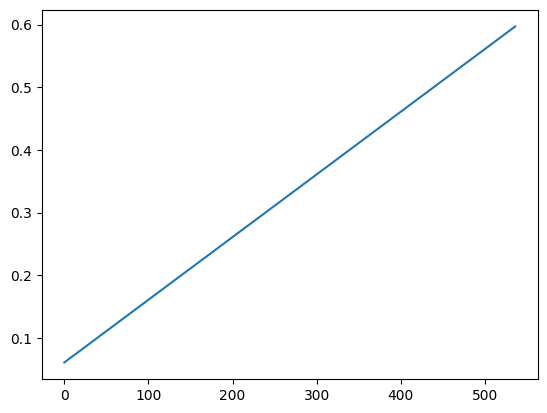

In [53]:
# Verify that this is affine
reconstructed_voltages = []
for i in range(len(constants.DAC_BINARY)):
    reconstructed_voltages.append(to_mv(constants.DAC_BINARY[i])*TIA_BIAS[constants.OPTIMAL_BIAS[i]])

plt.plot(np.arange(len(reconstructed_voltages)), reconstructed_voltages)
plt.show()

In [47]:
"""
endV < startV
"""

class SWV_States (enum.Enum):
    HIGH_V = 0
    LOW_V = 1

def swv_backwards(startV, endV, incrE, amplitude):
    amplitude = int(amplitude*1000)
    incrE = int(incrE*1000)
    baseMV = int(startV*1000) - amplitude
    endMV = int(endV*1000)
    state = SWV_States.HIGH_V
    while baseMV+amplitude > endMV:
        match(state):
            case SWV_States.HIGH_V:
                yield(baseMV+amplitude)
                state = SWV_States.LOW_V
            case SWV_States.LOW_V:
                yield(baseMV-amplitude)
                baseMV -= incrE
                state = SWV_States.HIGH_V

In [49]:
def const_array(vname, array, dtype="uint8_t", spacing = 10):
  out = ("const " + dtype + " " + vname + "[" + str(len(array)) + "] PROGEM = {")
  len_zeros = len(out)
  for i in range(math.floor(len(array) / spacing)):
    for j in range(spacing):
      out += "{}, ".format(array[i*spacing+j])
    out += "\n" + " " * len_zeros
  for i in range(math.floor(len(array) / spacing) * spacing, len(array)):
    out += "{}, ".format(array[i])
  out += "};"
  return out

def v_to_binary(v, bits, vref):
  return np.rint(v * 2**bits / vref).astype("int")

In [50]:
def generate_c_arrays(startV, endV, incrE, amplitude, graph=False):
    biases = []
    voltages = []
    if graph:
        mv_list = []
    n = 0
    for mv in swv_backwards(startV, endV, incrE, amplitude):
        bias, dac_v = get_mv(abs(mv))
        biases.append(bias)
        voltages.append(dac_v)
        n += 1
        if graph:
            mv_list.append(mv)

    if graph:
        reconstructed_voltages = [-to_mv(voltages[i]) * TIA_BIAS[biases[i]] for i in range(len(biases))]
        steps = np.arange(len(reconstructed_voltages))
        plt.step(steps[:100], reconstructed_voltages[:100], where="post")
        plt.title("Reconstructed Voltages vs n")
        plt.xlabel("n")
        plt.ylabel("Voltage (v)")
        plt.show()
        plt.plot(steps, reconstructed_voltages - np.array(mv_list)/1000)
        plt.title("Deviation vs n")
        plt.xlabel("n")
        plt.ylabel("Deviation (V)")
        plt.show()


    out_str = "// THIS FILE IS PROCEDURALLY GENERATED\n"
    out_str += "#include <avr/pgmspace.h>\n\n"
    out_str += const_array("BIASES", biases)
    out_str += "\n\n" + const_array("DAC_OUT", voltages, dtype="uint16_t")
    out_str += "\n\n" + "const uint16_t VOLTAMMETRY_LENGTH = {};".format(n)
    return out_str

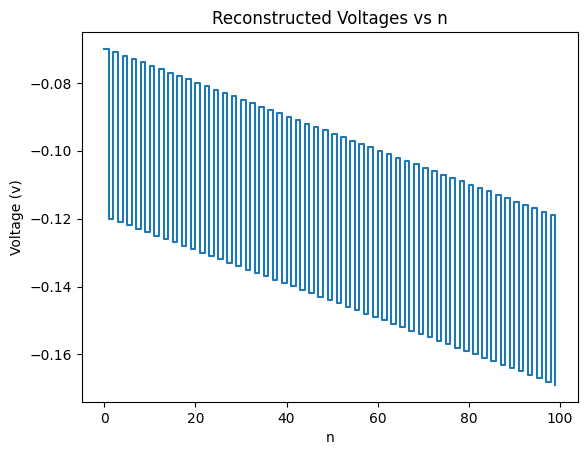

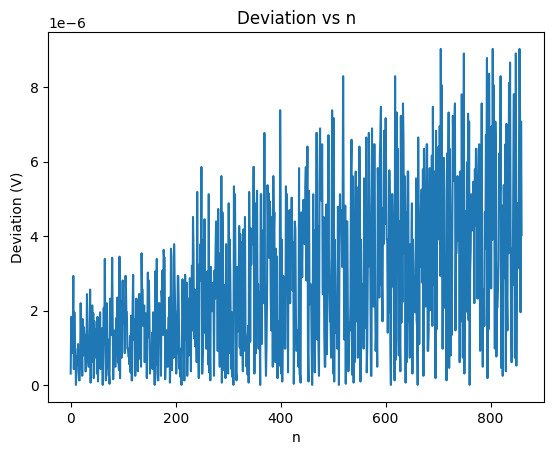

In [51]:
out_str = generate_c_arrays(-0.07, -0.5, 0.001, 0.025, True)

In [52]:
with open('swv.h', 'w') as f:
    f.write(out_str)